# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

Train RMSE: 133.2070273711007
Train R squared measure:0.2578551947886396
Test RMSE: 102.98672612727042
Test R squared measure:0.3089705222263943
Partial R² Host Id: 0.0023


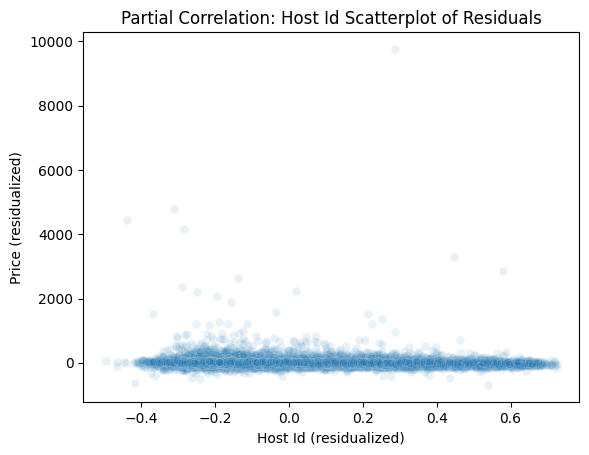

Partial R² Review Scores Rating (bin): 0.0001


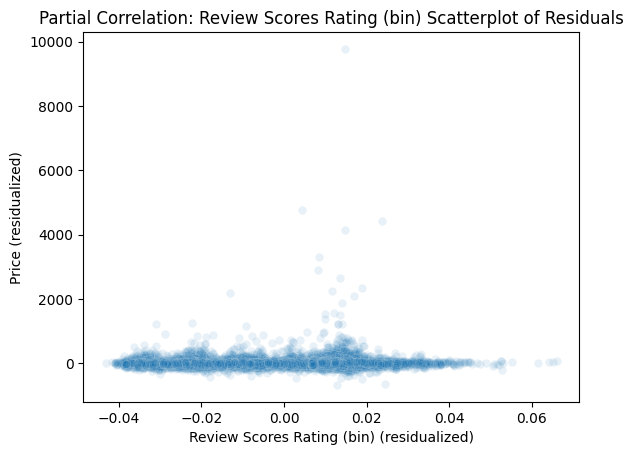

Partial R² Zipcode: 0.0010


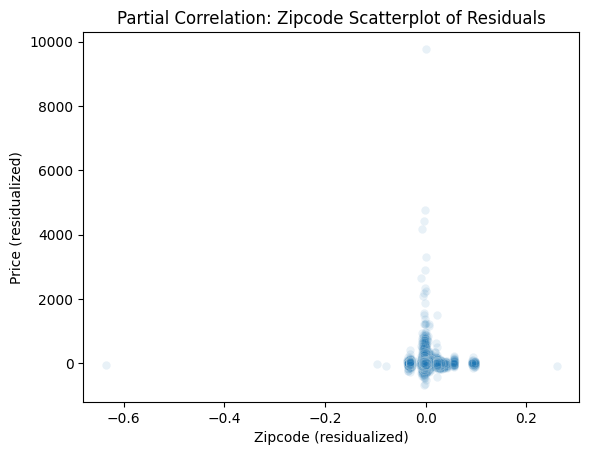

Partial R² Beds: 0.0905


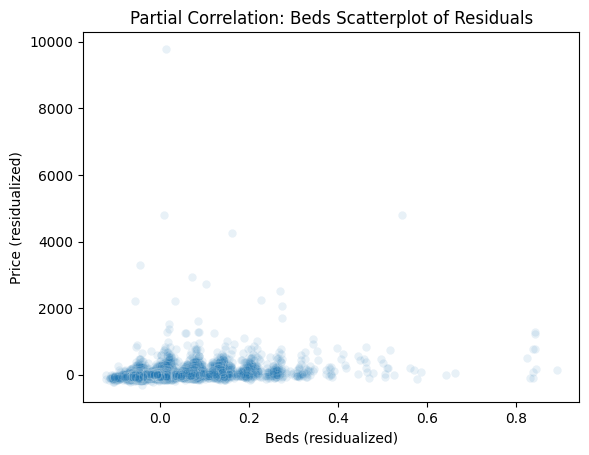

Partial R² Number of Records: 0.0009


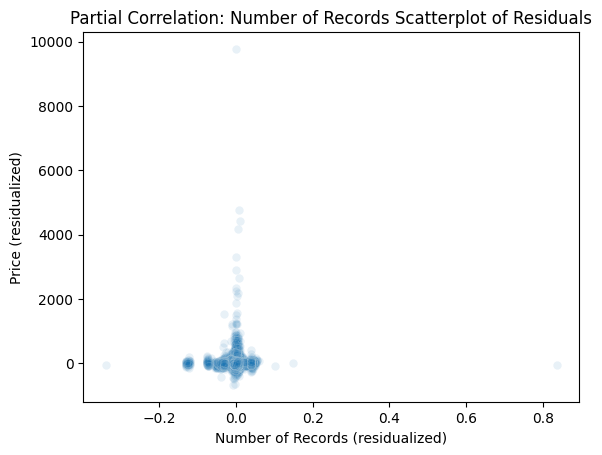

Partial R² Number Of Reviews: 0.0025


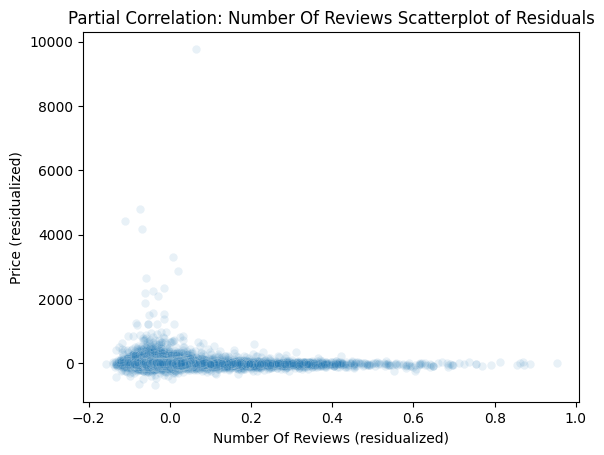

Partial R² Review Scores Rating: 0.0000


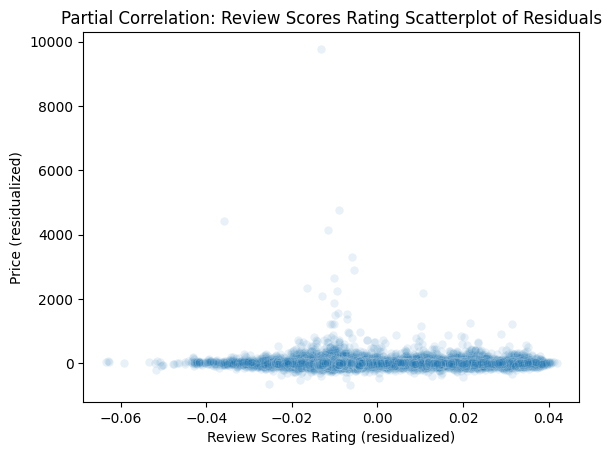

Train RMSE: 135.2914412639245
Train R squared measure:0.23444741891197307
Test RMSE: 102.33304107221322
Test R squared measure:0.3177149901300339


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

#1
df = pd.read_csv('linearModels/lab/data/airbnb_hw.csv')

# drop rows with NaN values
df = df.dropna()
# Remove '$' and ',' then convert to float
df.loc[:, 'Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

#2
# Selecting relevant numeric and categorical variables
numeric_columns = ['Host Id','Review Scores Rating (bin)','Zipcode','Beds','Number of Records','Number Of Reviews','Review Scores Rating']
categorical_columns = ['Neighbourhood ','Property Type', 'Room Type']

y = df['Price']
X = df[numeric_columns + categorical_columns].copy()
# Maxmin normalization function; Sci-kit calls it the "standard scaler" (changed for constant values)
def maxmin(z):
    return (z - z.min()) / (z.max() - z.min()) if z.min() != z.max() else z

X[numeric_columns] = X[numeric_columns].apply(maxmin) # Normalize X

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
#3
# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X, y, # Feature and target variables
                                                    test_size=0.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

#4
train_reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
y_train_pred = train_reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Train RMSE: {train_rmse}")
print(f"Train R squared measure:{train_reg.score(X_train, y_train)}") # R squared measure

test_reg = LinearRegression().fit(X_test, y_test) # Fit the linear model
y_test_pred = test_reg.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse}")
print(f"Test R squared measure:{test_reg.score(X_test, y_test)}") # R squared measure

#The test values did better, as the RMSE is lower. This means there is less of an error. The R squared value is also higher. It is closer to a moderate fit with more correlation.

def partial_correlation_plot(X, y, var, title_prefix=""):
    x_k = X[var]
    X_mk = X.drop(var, axis=1)

    # Step 1: Regress y on X\{k}, get residuals
    r_y = y - LinearRegression(fit_intercept=False).fit(X_mk, y).predict(X_mk)

    # Step 2: Regress x_k on X\{k}, get residuals
    r_x = x_k - LinearRegression(fit_intercept=False).fit(X_mk, x_k).predict(X_mk)

    # Step 3: Regress r_y on r_x
    partial_reg = LinearRegression().fit(r_x.to_numpy().reshape(-1, 1), r_y.to_numpy())
    partial_r2 = partial_reg.score(r_x.to_numpy().reshape(-1, 1), r_y.to_numpy())

    print(f'Partial R² {var}: {partial_r2:.4f}')

    # Plot residuals
    sns.scatterplot(y=r_y, x=r_x, alpha=0.1)
    plt.title(f'{title_prefix}{var} Scatterplot of Residuals')
    plt.xlabel(f'{var} (residualized)')
    plt.ylabel('Price (residualized)')
    plt.show()

for var in numeric_columns:
    partial_correlation_plot(X, y, var, title_prefix="Partial Correlation: ")

#6
## Function to winsorize a variable:
def winsorize(x):
    # Convert from pd to np, if necessary:
    if type(x) == 'pandas.core.series.Series':
        x = x.to_numpy()
    # Compute IQR and 25, 75 quantiles:
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Winsorize x:
    x_winsor = np.copy(x)
    x_winsor[ x < lower_whisker ] = lower_whisker
    x_winsor[ x > upper_whisker ] = upper_whisker
    return(x_winsor)

df.loc[:, ['Host Id','Review Scores Rating (bin)','Zipcode','Beds','Number of Records','Number Of Reviews','Review Scores Rating'] ] = df.loc[:,['Host Id','Review Scores Rating (bin)','Zipcode','Beds','Number of Records','Number Of Reviews','Review Scores Rating'] ].apply(winsorize)
df['Zipcode'] = np.arcsinh(df['Zipcode'])
df['Number of Records'] = np.arcsinh(df['Number of Records'])
X = df[numeric_columns + categorical_columns].copy()
X[numeric_columns] = X[numeric_columns].apply(maxmin) # Normalize X
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X, y, # Feature and target variables
                                                    test_size=0.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes


train_reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
y_train_pred = train_reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Train RMSE: {train_rmse}")
print(f"Train R squared measure:{train_reg.score(X_train, y_train)}") # R squared measure

test_reg = LinearRegression().fit(X_test, y_test) # Fit the linear model
y_test_pred = test_reg.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse}")
print(f"Test R squared measure:{test_reg.score(X_test, y_test)}") # R squared measure

#There is a better R squared and RMSE value.
